*SIO221a Notes - Alford and Gille*

*Reading: Bendat and Piersol Ch. 8.5.4, 5.2.3*

Concepts covered: Powerful properties of the Fourier transform


# Lecture 8

*Recap* 

Last time we looked at the Fourier transform, which lets us re-represent data
in the time (or space) domain in terms of coefficients of sines and cosines. 

Today we're going to look at 3 really key concepts for Fourier transforms, before we get on to computing the spectrum, next.

Before we do though, our example in class last time was a little unsatisfying because we didn't go to the trouble of defining which frequencies correspond to each Fourier coefficient.  Let's do that now.

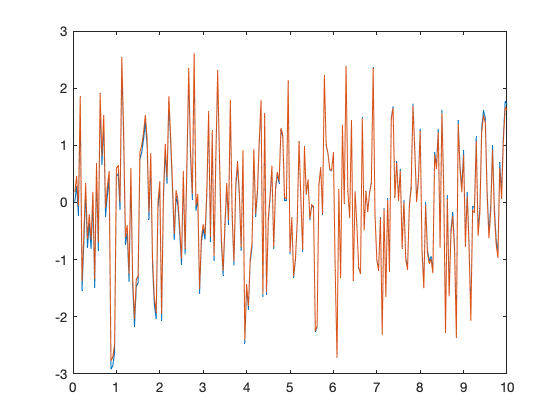

In [50]:
%Same example as before, but let's fix our notation.
%Let's make a signal plus some noise
dt=1/24; %1 hour samples
time=dt:dt:10; %time in days
N=length(time);
P=12.4/24;
x=randn(size(time))+sin(2*pi.*time ./ P);
%2nd time through: remove mean.
%X=X-mean(X);
X=fft(x);

x_new=ifft(X);
plot(time,x,time,x_new)


So to make a frequency vector that makes sense, we need to do two things.  First, we recall that the way MATLAB stores the Fourier coefficients is odd (at least to me) - the mean is in bin 1, and the highest frequencies are in the middle.  We can use 'fftshift' to swap the two halves of the Fourier coefficients so that zero frequency (the mean) is in the middle.  This better matches our definition from the previous lecture, where we have a 'picket fence' of frequencies, -$f_N$ to $f_N$. Here, $f_N=\frac{1}{2\Delta t}$ is the highest (Nyquist) frequency, and the picket fence of frequencies we are able to resolve is spaced by $\Delta f = 1/T$ where $T$ is our overall time series length.

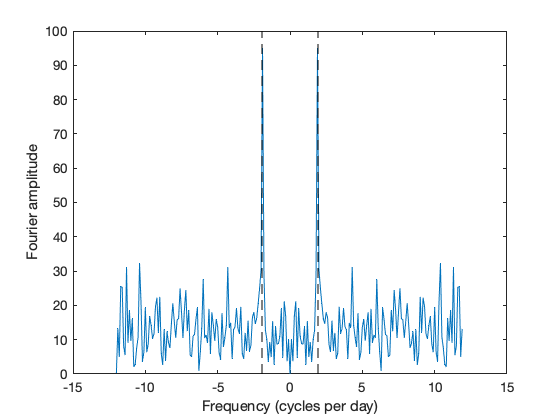

In [51]:
%% which freqs do these correspond to?
T=dt*N;

df=1/T;
fn=1/2/dt;
f=-fn:df:(fn-df); %frequency vector, cpd, goes from 0 to Nyquist.
length(f);
%MATLAB annoyingly puts the 
Xs=fftshift(X);
%We can plot the Fourier coefficients too.
plot(f,abs(Xs))
freqline(1/P);
freqline(-1/P);
xlabel('Frequency (cycles per day)')
ylabel('Fourier amplitude')


A couple of things to note here: first, the peaks now show up at $-1/P$ and $1/P$.  Remember, for real time series these are complex conjugates of each other, so their amplitude is identical.  For this reason, many people simply plot only half of the spectrum since the other half gives no extra information for real time series.

Second, recall that the Nyquist frequency is half the sample freqeuncy - where the half again comes from our need to use positive and negative frequencies to get phase right (or if we had used sines and cosines as before).


### Three great traits of the Fourier transform

We've talked about the effectiveness of the Fourier transform for
identifying frequencies that are particularly energetic
without having to know a priori what frequencies might have resonant peaks, and
we've noted that the Fourier transform is useful for evaluating the size of
one peak relative to another.

* 1.  Derivatives in time become multiplication in the frequency domain.*

Fourier coefficients have some additional mathematical power.  For example,
suppose I want to take the time derivative of my data.  If I start with

$$
x(t) = \int_{-\infty}^{\infty} X(f)  e^{i2\pi ft}\, df
$$

then
$$
\frac{\partial x}{\partial t} = \frac{\partial}{\partial t}\int_{-\infty}^{\infty} X(f)e^{i2\pi ft}\, df
$$
$$
= \int_{-\infty}^{\infty} 2i\pi f X(f)e^{i2\pi ft}\, df
$$
So the Fourier coefficients of the derivative are those of the undifferentiated time series multipled by $2i\pi f$.

Or I can also do the same with the discrete Fourier transform:
$$
A(t) = \sum_{n=-\infty}^\infty a_n e^{i2\pi f_n t}
$$

then

$$
\frac{\partial A}{\partial t} = \sum_{n=-\infty}^\infty a_n \frac{\partial e^{i2\pi f_n t}}{\partial t} = \sum_{n=-\infty}^\infty i2\pi f_n a_n e^{i2\pi f_n t}
$$

So the first derivative becomes a multiplication by frequency.
Higher derivatives are similarly simple:

$$
\frac{\partial^q A(t)}{\partial t^q} = \sum_{n=-\infty}^\infty (i2\pi f_n)^q a_n e^{i2\pi f_n t}.
$$

Integration can be represented as a division operation:

$$
\int{A(t)}\, dt = \sum_{n=-\infty}^\infty (i2\pi f_n)^{-1} a_n e^{-i2\pi f_n t}
$$

though we'll run into a bit of trouble if $f_0\ne 0$, that is if the record
has a non-zero mean.  That can mean that we might want to remove the mean
before we start doing anything more complicated.

Before we move to the next amazing Fourier factoid, let's do a quick physical example to show why this first one is so cool.

Say we have a frictional (damped) spring system such as that in section 2.4 of B&P. If $y(t)$ is the displacement of the mass, we can write down the force balance of the system as (spring force) + (friction force) + (inertial force) equals the external force $F$:

$$
m\ddot{y}(t)+ c\dot{y}(t)+ky(t)=F(t)
$$

This is known as a linear physical system, and Fourier analysis shines here because we can simply relate the frequency response of the system using our newfound technique above.  If $Y(f)$ is the Fourier transform of $y(t)$, then by Fourier transforming we get:

$$-m(2\pi f)^2 Y + c i 2 \pi f Y + k Y = \tilde{F}(f),
$$
where $\tilde{F}$ is the Fourier transform of the external force.

We can then rearrange to obtain:

$$
Y/F = \frac{1}{k - (2\pi f)^2m + c i 2\pi f},
$$

which gives us a nice way of relating the frequency response of a system to external forcing.  For example, if this were a damped pendulum, a tiny bit more analysis would give us the pendulum frequency and the degree of damping. For example, if damping $c$=0, we would have a resonance at $f_r=\frac{1}{2\pi}\sqrt{\frac{k}{m}}$.

Some of you may remember analysis of linear systems from your physics classes.  If not, store this away as you will surely encounter them soon.

2.  Fourier transforms simplify convolution.

Suppose you plot some noisy data---the time series features crazy amplitude swings,
and no one can make any sense of it, but you think that hiding behind
all this noise, there might be a slowly varying signal.  You might be told,
just do a running mean to smooth it out.   That running mean is a convolution.

Convolution plays an important role in thinking about the Fourier
transform, so we need to spend a little time on the concept.
Here's the basic convolution integral:

$$
y(t) = \int_{-\infty}^{\infty} h(\tau) x(t-\tau) d\tau.
$$

You can think of $x$ as the data, and $h$ as a filtering operator (such as
a "boxcar" filter, or a triangle filter, or a roughly Gaussian-shaped window,
or anything else that suits you.

In Matlab you can do this as:

In [46]:
%First we can add it to our path:
%You might need to modify this depending on your path and current directory.
addpath('/Users/malford/GoogleDrive/Work/Projects/Teaching/sio221a/SIO221a_Github_code/')
pier=Get2020PierData(datenum(2020,6,4,0,0,0),datenum(2020,6,7,0,0,0))
data=pier.temperature;
time=pier.dnum;
y=conv(data(:),boxcar(12)/12);
size(y)
%which produces the same results as:  y=filter(boxcar(12)/12,1,data(:));


pier = 

  struct with fields:

           dnum: [1076x1 double]
    temperature: [1076x1 single]
       pressure: [1076x1 single]
         readme: '2020 Pier data, SIO221a, function Get2020PierData.m'


ans =

        1087           1



In both cases these will be shifted by half the width of the filter, so we can
plot:

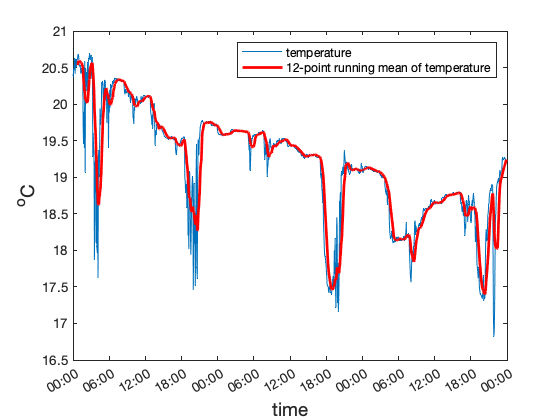

In [47]:
convdata=conv(data(:),boxcar(12)/12);
plot(time(:),data(:))
datetick
hold on
plot(time(12:length(time)),convdata(12:length(time)),'r','LineWidth',2)
hold off
xlabel('time','FontSize',14)
ylabel('^oC','FontSize',14)
legend('temperature','12-point running mean of temperature')

Alternately, you can use the CenteredConv.m code in the repo, which avoids some of the annoying properties of the functions above including shifted data and different length of the answer from the original.

Formally the notation for a convolution of two records $h$ and $x$ is written

$$
h* x = \int_{-\infty}^\infty h(\tau)x(t - \tau) d\tau.
$$

What happens if we Fourier transform this?

$$
\mathcal{F}(h\ast x)  = \int_{-\infty}^{\infty}\left[
\int_{-\infty}^\infty h(\tau)x(t - \tau) d\tau\right]e^{i t2\pi f}\, dt\\
$$

$$
=  \int_{-\infty}^{\infty}h(\tau) \int_{-\infty}^\infty \left[x(t - \tau)e^{i t2\pi f}\, dt\right] d\tau \\
$$

$$
  =  \int_{-\infty}^{\infty}h(\tau)e^{i\tau 2\pi f}\mathcal{F}(x(f))\, d\tau \\
$$

$$
  =  \mathcal{F}(h)\mathcal{F}(x)
$$

where here I've represented the Fourier transform with a script $\mathcal{F}$.

This has profound consequences.  It means that anything that required a
convolution in the time domain I can handle trivially in the Fourier
domain.  Suppose I want to filter my data.  If I don't like the hassle
of convolving, I can just Fourier transform, multiply by the Fourier transform
of my filter, and inverse Fourier transform.  This will prove to be
amazingly powerful.



3.  Parseval's theorem:  Total variance in the time domain equals total variance in the frequency domain

The third trait of the Fourier transform is that it conserves energy
(or variance).  Formally, we refer to this as Parseval's theorem, and
we'll take a closer look later.

Parseval's  theorem provides a critical link between total energy in the
time domain and total energy in the Fourier transform domain.  There are a 
couple of ways to think about this.  



*3.1 Parseval's theorem from the definition of the Fourier transform.*

The simplest way to understand Parseval's theorem is to prove it directly. Consider the product of two variables, $x_1$ and $x_2$.
We can rewrite the product, substituting the Fourier transform of $x_2(t)$:

$$
x_1(t) x_2(t)  = x_1(t)\int_{-\infty}^{\infty}{X_2}(f)e^{i 2\pi f t}\, df
$$

so we can integrate this in time:

$$
\int_{-\infty}^{\infty} x_1(t) x_2(t)dt  = \int_{-\infty}^\infty
\left[x_1(t)\int_{-\infty}^{\infty}{X_2}(f)e^{i 2\pi f t}\, df\right]\, dt\\
$$

$$
 \int_{-\infty}^{\infty}{X_2}(f)\left[\int_{-\infty}^{\infty}
x_1(t)e^{i 2\pi f t}dt\right]df\\
$$

$$
 =  \int_{-\infty}^{\infty}{X_1}^*(f){X_2}(f)\, df.
$$

(My edition of Bendat and Piersol has a typo in this derivation, which appears
just prior to equation 5.83, and this has caused no end of confusion.)
Here we use the complex conjugate of the Fourier transform of $x_1$, because
we computed the Fourier transform with $e^{+i2\pi ft}$ instead of the
standard $e^{-i2\pi ft}$.

Put succinctly, if $x_1=x_2$:

$$
\int_{-\infty}^{\infty} x^2(t) dt  = \int_{-\infty}^\infty  |{X}(f)|^2\, df
$$

This is Parseval's relationship.


It's worth noting that if we worked with $\sigma=2\pi f$ rather than $f$, we'd have to
normalize by $2\pi$:

$$
\int_{-\infty}^{\infty} x^2(t) dt  = \frac{1}{2\pi} \int_{-\infty}^\infty  |X(\sigma)|^2\, d\sigma
$$

In thinking about the time domain vs the frequency domain, one thing to
keep in mind is the distinction between integrating over all time (on 
the left in the above equation) and integrating over all frequency (on the right).
This implies that we're going to need to keep track of our frequency information carefully.  In essence the Fourier coefficients in $X$ (e.g. $|a_m|^2$) do not 
have the same units as the time domain values in $x^2$, 
because $x$ is integrated in time and $|a_m|$ is integrated in frequency.
If the total integral of $x^2$ is equal to the total integral of 
$|X|^2$, then we're going to need to adjust by factors
of $\delta f$, and this will influence how we label our axes.

 * 3.2 Parseval's theorem via convolution.*
Let's start with the convolution 
of a data record with itself:

$$
y(t) = \int_{-\infty}^{\infty} x(\tau) x(t-\tau) d\tau.
$$


What happens if I convolve my data ($x(t)$) with the time reversal of
itself ($x(-t)$)?

$$
y(t) = \int_{-\infty}^{\infty} x(\tau) x(t+\tau) d\tau.
$$

More conventionally we might write:

$$
y(\Delta t) = \int_{-\infty}^{\infty} x(t) x(\Delta t+t) dt.
$$

So we're looking at the data multiplied by itself for a time lag $\Delta t$.
At zero lag, this is the variance, and as we vary $\Delta t$ we're looking
at the lagged covariance for different time lags.

What about the Fourier transform?  The Fourier transform of a convolution is simply the
product of the Fourier transforms of each variable so the Fourier transform of $y(\Delta t)$
shoud be $X^*X$.  (We use the complex conjugate of $X$ since we convolved $x$ with its time
reversal.)  We could inverse transform this back to produce $y(\Delta t)$:

$$
y(\Delta t) = \int_{-\infty}^\infty X^*X e^{i 2\pi f \Delta t}\, df
$$

Now, focus on the case when $\Delta t = 0$.  This implies that

$$
y(0) = \int_{-\infty}^{\infty} x(t)^2 dt = \int_{-\infty}^\infty X^*X \, df,
$$

which tells us that the total variability in $x$ is equivalent to the total variability in 
its Fourier transform $X$.


*More on the formalism of the Fourier transform*

Now we can use this to verify that our Fourier coefficients are consistent.  If
I have a data set $x(t)$ that can be expressed as

$$
x(t) = \sum_{n=-\infty}^\infty a_n \exp(i2\pi f_n t)
$$

and

$$
a_m = \frac{1}{T}\int_{-T/2}^{T/2} x(t) \exp(-i2\pi f_m t)\, dt
$$

then let's check that our coefficients work out.
We can substitute in $x(t)$ to obtain

$$
a_m = \frac{1}{T}\int_{-T/2}^{T/2}  \sum_{n=-\infty}^\infty a_n \exp(i2\pi f_n t) \exp(-i2\pi f_m t)\, dt \\
$$

$$
 =  \frac{1}{T}\int_{-T/2}^{T/2}  \sum_{n=-\infty}^\infty a_n  \exp(i2\pi (f_n-f_m) t)\, dt \\
$$

$$
 =  \sum_{n=-\infty}^\infty \frac{a_n}{T}\int_{-T/2}^{T/2}  \exp(i(f_n-f_m) t)\, dt.
$$
When $n=m$, the integral goes to $T$, and the summed expression becomes $a_n$.
When $n\ne m$, we're dealing with orthogonal cosines and sines, and the integral
goes to zero.  Thus the net result is that

$$
a_m = \sum_{n=-\infty}^\infty a_n\delta_{nm} \\
$$

$$
  = a_m
$$
where $\delta_{nm}$ is called the Kronecker delta function, with $\delta_{nm}=1$ if
$n=m$ and $\delta_{nm}=0$ otherwise.  (Formally in continuous form the $\delta$
function can
be thought of as a
distribution, like a pdf, that has shrunk to be infinitely high and infinitesimally
narrow, so that the area under the distribution is exactly 1.)
